In [1]:
import pandas as pd
import numpy as np
import pandas_profiling as ProfileReport
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.regression.linear_model import OLS 
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score

In [33]:
%matplotlib inline

In [29]:
df_caminhoes = pd.read_excel('D:/MyGitHubProjects/Ciência_de_Dados_e_Inteligência_Artificial_Aplicada/BD_Caminhoes.xlsx')

In [30]:
df_caminhoes = df_caminhoes.iloc[:,:5].dropna()

In [31]:
df_caminhoes

,Data,Caminhões_Emplac,Automóveis_Com_Emplac,Câmbio,Óleo Diesel - Preço
0,2002-01-01,5328.0,108254.0,2.377100,0.8835
1,2002-02-01,4561.0,91737.0,2.418800,0.8784
2,2002-03-01,5310.0,116635.0,2.345800,0.8894
3,2002-04-01,5346.0,131601.0,2.319600,0.9583
4,2002-05-01,6255.0,115136.0,2.479600,0.9762
...,...,...,...,...,...
236,2021-09-01,11565.0,142339.0,5.279090,4.7280
237,2021-10-01,11086.0,150068.0,5.539375,5.0330
238,2021-11-01,10559.0,161016.0,5.556260,5.3590
239,2021-12-01,11985.0,193529.0,5.650604,5.3470


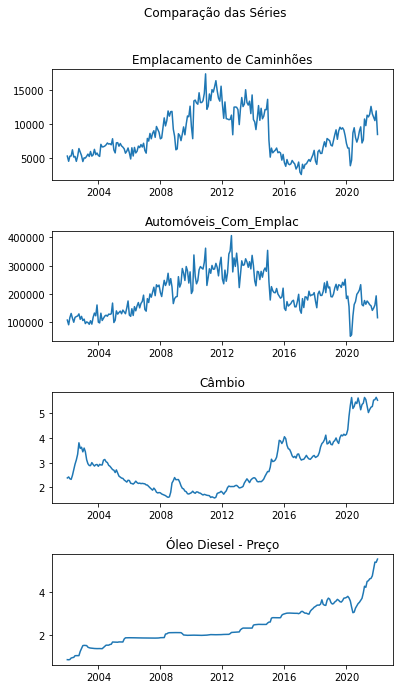

In [38]:
fig, axs = plt.subplots(4,figsize=(6,10))
fig.suptitle('Comparação das Séries')
fig.tight_layout(pad=3.0)
axs[0].title.set_text('Emplacamento de Caminhões')
axs[1].title.set_text('Automóveis_Com_Emplac')
axs[2].title.set_text('Câmbio')
axs[3].title.set_text('Óleo Diesel - Preço')
axs[0].plot(df_caminhoes['Data'], df_caminhoes['Caminhões_Emplac'])
axs[1].plot(df_caminhoes['Data'],df_caminhoes['Automóveis_Com_Emplac'])
axs[2].plot(df_caminhoes['Data'],df_caminhoes['Câmbio'])
axs[3].plot(df_caminhoes['Data'],df_caminhoes['Óleo Diesel - Preço'])

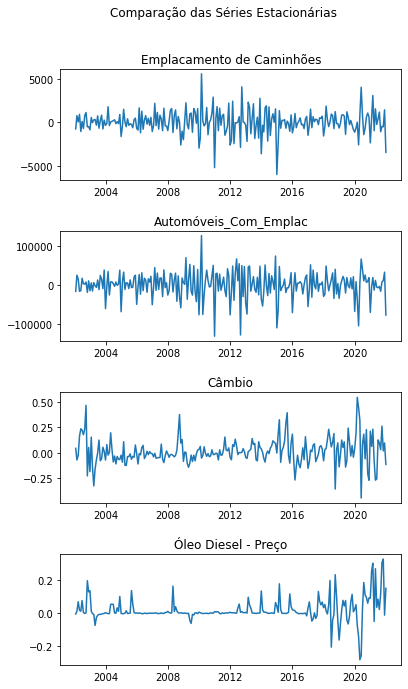

In [39]:
fig, axs = plt.subplots(4,figsize=(6,10))
fig.suptitle('Comparação das Séries Estacionárias')
fig.tight_layout(pad=3.0)
axs[0].title.set_text('Emplacamento de Caminhões')
axs[1].title.set_text('Automóveis_Com_Emplac')
axs[2].title.set_text('Câmbio')
axs[3].title.set_text('Óleo Diesel - Preço')
axs[0].plot(df_caminhoes['Data'], df_caminhoes['Caminhões_Emplac'].diff())
axs[1].plot(df_caminhoes['Data'],df_caminhoes['Automóveis_Com_Emplac'].diff())
axs[2].plot(df_caminhoes['Data'],df_caminhoes['Câmbio'].diff())
axs[3].plot(df_caminhoes['Data'],df_caminhoes['Óleo Diesel - Preço'].diff())

In [40]:
df_caminhoes[['Caminhões_Emplac','Automóveis_Com_Emplac','Câmbio','Óleo Diesel - Preço']].corr()

,Caminhões_Emplac,Automóveis_Com_Emplac,Câmbio,Óleo Diesel - Preço
Caminhões_Emplac,1.000000,0.783903,-0.344036,0.011663
Automóveis_Com_Emplac,0.783903,1.000000,-0.423845,0.071396
Câmbio,-0.344036,-0.423845,1.000000,0.740158
Óleo Diesel - Preço,0.011663,0.071396,0.740158,1.000000


In [42]:
ad_fuller_result_1 = adfuller(df_caminhoes['Caminhões_Emplac'])
ad_fuller_result_2 = adfuller(df_caminhoes['Automóveis_Com_Emplac'])
ad_fuller_result_3 = adfuller(df_caminhoes['Câmbio'])
ad_fuller_result_4 = adfuller(df_caminhoes['Óleo Diesel - Preço'])

Ad_fuller = pd.DataFrame({'Caminhões Emplacamento':[ad_fuller_result_1[0],ad_fuller_result_1[1]],'Automóveis Emplacamento':[ad_fuller_result_2[0],ad_fuller_result_2[1]], 'Câmbio':[ad_fuller_result_3[0],ad_fuller_result_3[1]], 'Óleo Diesel':[ad_fuller_result_4[0],ad_fuller_result_4[1]]})
Ad_fuller.rename(index={0:'ADF Statistic',1:'p-value'},inplace=True)

Ad_fuller

,Caminhões Emplacamento,Automóveis Emplacamento,Câmbio,Óleo Diesel
ADF Statistic,-2.088053,-1.452867,0.141701,1.761759
p-value,0.249346,0.556685,0.968796,0.998270


In [44]:
ad_fuller_result_1 = adfuller(df_caminhoes['Caminhões_Emplac'].diff()[1:])
ad_fuller_result_2 = adfuller(df_caminhoes['Automóveis_Com_Emplac'].diff()[1:])
ad_fuller_result_3 = adfuller(df_caminhoes['Câmbio'].diff()[1:])
ad_fuller_result_4 = adfuller(df_caminhoes['Óleo Diesel - Preço'].diff()[1:])

Ad_fuller = pd.DataFrame({'Caminhões Emplacamento':[ad_fuller_result_1[0],ad_fuller_result_1[1]],'Automóveis Emplacamento':[ad_fuller_result_2[0],ad_fuller_result_2[1]], 'Câmbio':[ad_fuller_result_3[0],ad_fuller_result_3[1]], 'Óleo Diesel':[ad_fuller_result_4[0],ad_fuller_result_4[1]]})
Ad_fuller.rename(index={0:'ADF Statistic',1:'p-value'},inplace=True)

Ad_fuller.round(3)

,Caminhões Emplacamento,Automóveis Emplacamento,Câmbio,Óleo Diesel
ADF Statistic,-4.497,-5.591,-5.729,-10.093
p-value,0.000,0.000,0.000,0.000


In [49]:
print('O Emplacamento de caminhões impacta o Câmbio?\n')
print('-------------------------------')
granger_1 = grangercausalitytests(df_caminhoes[['Câmbio','Caminhões_Emplac']].diff()[1:],2)
print('\n-------------------------------\n')
print('O Câmbio Afeta o emplacamento de caminhões?\n')
print('-------------------------------')
granger_2 = grangercausalitytests(df_caminhoes[['Caminhões_Emplac','Câmbio']].diff()[1:],2)
print('\n-------------------------------\n')
print('O Óleo diesel afeta o emplacamento de caminhões?\n')
print('-------------------------------')
granger_2 = grangercausalitytests(df_caminhoes[['Caminhões_Emplac','Óleo Diesel - Preço']].diff()[1:],2)
print('\n-------------------------------\n')
print('O emplacamento de caminhões afeta o óleo diesel?\n')
print('-------------------------------')
granger_2 = grangercausalitytests(df_caminhoes[['Óleo Diesel - Preço','Caminhões_Emplac']].diff()[1:],2)


O Emplacamento de caminhões impacta o Câmbio?

-------------------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6169  , p=0.2048  , df_denom=236, df_num=1
ssr based chi2 test:   chi2=1.6375  , p=0.2007  , df=1
likelihood ratio test: chi2=1.6319  , p=0.2014  , df=1
parameter F test:         F=1.6169  , p=0.2048  , df_denom=236, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0756  , p=0.3428  , df_denom=233, df_num=2
ssr based chi2 test:   chi2=2.1974  , p=0.3333  , df=2
likelihood ratio test: chi2=2.1873  , p=0.3350  , df=2
parameter F test:         F=1.0756  , p=0.3428  , df_denom=233, df_num=2

-------------------------------

O Câmbio Afeta o emplacamento de caminhões?

-------------------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6373  , p=0.1057  , df_denom=236, df_num=1
ssr based chi2 test:   chi2=2.6708  , p=0.1022  , df=1
likelihood ratio test: chi2=2.65

In [50]:
print('O Emplacamento de automóveis impacta o Câmbio?\n')
print('-------------------------------')
granger_1 = grangercausalitytests(df_caminhoes[['Câmbio','Automóveis_Com_Emplac']].diff()[1:],4)
print('\n-------------------------------\n')
print('O Câmbio Afeta o emplacamento de automóveis?\n')
print('-------------------------------')
granger_2 = grangercausalitytests(df_caminhoes[['Automóveis_Com_Emplac','Câmbio']].diff()[1:],4)
print('\n-------------------------------\n')
print('O Óleo diesel afeta o emplacamento de automóveis?\n')
print('-------------------------------')
granger_2 = grangercausalitytests(df_caminhoes[['Automóveis_Com_Emplac','Óleo Diesel - Preço']].diff()[1:],4)
print('\n-------------------------------\n')
print('O emplacamento de automóveis afeta o óleo diesel?\n')
print('-------------------------------')
granger_2 = grangercausalitytests(df_caminhoes[['Óleo Diesel - Preço','Automóveis_Com_Emplac']].diff()[1:],4)


O Emplacamento de automóveis impacta o Câmbio?

-------------------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6345  , p=0.4265  , df_denom=236, df_num=1
ssr based chi2 test:   chi2=0.6426  , p=0.4228  , df=1
likelihood ratio test: chi2=0.6418  , p=0.4231  , df=1
parameter F test:         F=0.6345  , p=0.4265  , df_denom=236, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4657  , p=0.6283  , df_denom=233, df_num=2
ssr based chi2 test:   chi2=0.9513  , p=0.6215  , df=2
likelihood ratio test: chi2=0.9494  , p=0.6221  , df=2
parameter F test:         F=0.4657  , p=0.6283  , df_denom=233, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3334  , p=0.8012  , df_denom=230, df_num=3
ssr based chi2 test:   chi2=1.0305  , p=0.7939  , df=3
likelihood ratio test: chi2=1.0283  , p=0.7944  , df=3
parameter F test:         F=0.3334  , p=0.8012  , df_denom=230, df_num=3

Granger Causa

In [59]:
lista = [] # Lista que armazenará cada avaliação cruzada
for i in range(20):
    df_treino_CV = df_caminhoes[['Câmbio','Automóveis_Com_Emplac']][:-24-i*5]
    if i != 0:
        df_teste_CV = df_caminhoes[['Câmbio','Automóveis_Com_Emplac']][-24-i*5:-i*5]
    else:
        df_teste_CV = df_caminhoes[['Câmbio','Automóveis_Com_Emplac']][-24-i*5:]
    
    print(df_treino_CV.shape)
    print(df_teste_CV.shape)
    print(f'\n----------------------------\n Cross-Validation número {i}\n----------------------------\n\n')

    l = [] # Lista que armazenará todos os LAGs
    for j in range(1,15):
        #Realizando o modelo denovo, ele rodará cerca de 240 vezes!
        try:
            var_model = VARMAX(df_treino_CV,order =(j,0), enforce_stationarity=True)
            fitted_model = var_model.fit(disp=False)
            predict = fitted_model.get_prediction(start=len(df_treino_CV),end=len(df_treino_CV) + 24 -1)
            predictions = predict.predicted_mean
            predictions.rename(columns = {'Câmbio':'Câmbio_Forecast','Automóveis_Com_Emplac':'Automóveis_Com_Emplac_Forecast'},inplace=True)
            # Adicionando comentários para manter certeza de que o modelo está rodando, de fato, e que não deu erro.
            print(f'LAG sendo Testado: {j}')
            print(f"MAE: {mean_absolute_error(df_teste_CV['Automóveis_Com_Emplac'],predictions['Automóveis_Com_Emplac_Forecast'])}")
            print(f"MSE: {mean_squared_error(df_teste_CV['Automóveis_Com_Emplac'],predictions['Automóveis_Com_Emplac_Forecast'])/10**6}")
            print(f"MAPE: {mean_absolute_percentage_error(df_teste_CV['Automóveis_Com_Emplac'],predictions['Automóveis_Com_Emplac_Forecast'])}")
            print(f"AIC: {fitted_model.aic}")
            print('------------------------')
            l.append({f'{j} LAGs:':[mean_absolute_error(df_teste_CV['Automóveis_Com_Emplac'],predictions['Automóveis_Com_Emplac_Forecast']),mean_squared_error(df_teste_CV['Automóveis_Com_Emplac'],predictions['Automóveis_Com_Emplac_Forecast'])/10**10, mean_absolute_percentage_error(df_teste_CV['Automóveis_Com_Emplac'],predictions['Automóveis_Com_Emplac_Forecast']),fitted_model.aic]})
        #Adicionando todos esses valores às listas. Utilizarei elas depois para plotar os gráficos com as estatísticas.
        except:
            l.append({f'{j} LAGs:{[0,0,0,0]}'})
            pass    
    lista.append({f'Cross{i}':l})

(217, 2)
(24, 2)

----------------------------
 Cross-Validation número 0
----------------------------




d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=2.97386e-20): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 1
MAE: 45055.24187546349
MSE: 2818.588120311259
MAPE: 0.36232742671463863
AIC: 4798.0416584846225
------------------------


d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=7.37204e-21): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 2
MAE: 39728.89377176847
MSE: 2576.0546834467928
MAPE: 0.35470468845737596
AIC: 4769.466378063929
------------------------


d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=1.44843e-21): result may not be accurate.
  x = solve(lhs, q.flatten())
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=8.4298e-22): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 3
MAE: 35972.16183252504
MSE: 2512.484430900346
MAPE: 0.34941261098273774
AIC: 4748.512744287689
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 4
MAE: 33689.131094630546
MSE: 2442.000428568101
MAPE: 0.34018740142614795
AIC: 4752.87601561298
------------------------
LAG sendo Testado: 5
MAE: 32076.761971978616
MSE: 2462.2546065633665
MAPE: 0.33993967962724536
AIC: 4752.297827042673
------------------------
LAG sendo Testado: 6
MAE: 31382.702385747212
MSE: 2427.786714567946
MAPE: 0.33627629803470255
AIC: 4758.245977844084
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 8
MAE: 31335.970008961944
MSE: 2437.6022626294407
MAPE: 0.33791424646408696
AIC: 4759.194854135561
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 9
MAE: 31043.71396134529
MSE: 2420.258200808643
MAPE: 0.33908557174665704
AIC: 4755.478950338596
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 10
MAE: 31174.309660278846
MSE: 2435.0265945306583
MAPE: 0.3371169666026815
AIC: 4762.126796612114
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 11
MAE: 30052.149696882876
MSE: 2322.1579063953263
MAPE: 0.33378860490459866
AIC: 4751.424943285734
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 12
MAE: 27219.946590404983
MSE: 2061.300274221949
MAPE: 0.31339489424828443
AIC: 4730.909991197791
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 13
MAE: 27388.420813635963
MSE: 2207.6312146878668
MAPE: 0.3185155393213613
AIC: 4726.091436272383
------------------------
LAG sendo Testado: 14
MAE: 116388.44904334472
MSE: 15254.337068880182
MAPE: 0.6865884182659423
AIC: 6459.989292936814
------------------------
(212, 2)
(24, 2)

----------------------------
 Cross-Validation número 1
----------------------------




d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=2.98262e-20): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 1
MAE: 47105.31842803309
MSE: 2937.1635434443438
MAPE: 0.3461950334949118
AIC: 4690.397595820487
------------------------


d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=4.43172e-21): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 2
MAE: 41627.17806761604
MSE: 2575.854075666407
MAPE: 0.3394206309795853
AIC: 4664.109285598957
------------------------


d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=8.80573e-22): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 3
MAE: 37091.87322812978
MSE: 2388.828126481503
MAPE: 0.33362370256488355
AIC: 4642.814222977197
------------------------


d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=5.17034e-22): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 4
MAE: 36319.21054141704
MSE: 2344.730370074408
MAPE: 0.32915424761107803
AIC: 4647.34974213406
------------------------
LAG sendo Testado: 5
MAE: 33990.26952043056
MSE: 2301.4937631188027
MAPE: 0.323683343888663
AIC: 4646.588827968175
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 6
MAE: 33564.03661050106
MSE: 2271.439539932243
MAPE: 0.3210932849395713
AIC: 4652.985286356572
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 8
MAE: 34196.134551395204
MSE: 2361.5387999200843
MAPE: 0.32729118819792835
AIC: 4654.42030264488
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 9
MAE: 32588.43981202597
MSE: 2375.9269126146246
MAPE: 0.3241569197598398
AIC: 4649.143949711024
------------------------
LAG sendo Testado: 11
MAE: 33237.120126268856
MSE: 2264.266432327322
MAPE: 0.3201034511608286
AIC: 4648.537386993017
------------------------
LAG sendo Testado: 13
MAE: 33657.45811516794
MSE: 2302.1569656794272
MAPE: 0.32671876968475005
AIC: 4622.414012627072
------------------------
LAG sendo Testado: 14
MAE: 127056.65548072178
MSE: 18478.474873320087
MAPE: 0.676725806687931
AIC: 6285.294942146773
------------------------
(207, 2)
(24, 2)

----------------------------
 Cross-Validation número 2
----------------------------




d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=2.53377e-20): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 1
MAE: 63528.04413841665
MSE: 4763.1983163696905
MAPE: 0.3887560697696164
AIC: 4579.814840886551
------------------------


d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=4.16535e-21): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 2
MAE: 58931.75915927469
MSE: 4139.563084433516
MAPE: 0.37472546282298497
AIC: 4551.460793402859
------------------------


d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=7.59078e-22): result may not be accurate.
  x = solve(lhs, q.flatten())
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=4.1888e-22): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 3
MAE: 57447.068420239164
MSE: 3950.089362202296
MAPE: 0.3740077116059796
AIC: 4530.256330795131
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 4
MAE: 56473.71069419489
MSE: 3842.646197541527
MAPE: 0.3702565490475221
AIC: 4534.384689106006
------------------------
LAG sendo Testado: 5
MAE: 53784.318501244124
MSE: 3562.89110289078
MAPE: 0.36234962305978646
AIC: 4533.906852279876
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 6
MAE: 52650.530635568255
MSE: 3459.302557282209
MAPE: 0.3584053704397432
AIC: 4540.80511700324
------------------------
LAG sendo Testado: 8
MAE: 56110.68038378498
MSE: 3823.066567430924
MAPE: 0.37294923753941617
AIC: 4544.5160233974475
------------------------
LAG sendo Testado: 9
MAE: 49146.511155115826
MSE: 3128.4845648706887
MAPE: 0.3518568157051843
AIC: 4536.174321567601
------------------------
LAG sendo Testado: 10
MAE: 50162.32671626857
MSE: 3237.2308878127265
MAPE: 0.35592568695392174
AIC: 4542.020148921876
------------------------
LAG sendo Testado: 11
MAE: 51649.88813648
MSE: 3316.782680599295
MAPE: 0.35644426760542736
AIC: 4533.1107174947965
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 12
MAE: 48947.3155527109
MSE: 2956.0957650357163
MAPE: 0.3451897251386545
AIC: 4509.647992630458
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 13
MAE: 46457.18192129128
MSE: 2754.2444311627173
MAPE: 0.33839805159246344
AIC: 4507.919238671937
------------------------
LAG sendo Testado: 14
MAE: 132296.3888871478
MSE: 20064.88657208084
MAPE: 0.6534144864238757
AIC: 6105.990144665593
------------------------
(202, 2)
(24, 2)

----------------------------
 Cross-Validation número 3
----------------------------




d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=2.40348e-20): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 1
MAE: 57802.70639515397
MSE: 4493.527710766902
MAPE: 0.3550372805118022
AIC: 4474.767547177422
------------------------


d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=6.34883e-21): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 2
MAE: 42585.02194136696
MSE: 2730.7748884994226
MAPE: 0.3156055210085269
AIC: 4443.90681997303
------------------------


d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=7.04844e-22): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 3
MAE: 36498.418262170126
MSE: 2203.497297288629
MAPE: 0.30718062649030803
AIC: 4422.664749479243
------------------------


d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=4.53309e-22): result may not be accurate.
  x = solve(lhs, q.flatten())
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 4
MAE: 36694.00456350471
MSE: 2227.4484348033448
MAPE: 0.30588440471750084
AIC: 4428.437462651567
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 5
MAE: 35099.063988169255
MSE: 2205.9979462842925
MAPE: 0.3093886391182679
AIC: 4425.570288309624
------------------------
LAG sendo Testado: 6
MAE: 34429.43974697445
MSE: 2198.7402658281094
MAPE: 0.3090306001779532
AIC: 4432.277092422354
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 8
MAE: 34743.22842629657
MSE: 2174.0979211047197
MAPE: 0.3032660572953309
AIC: 4434.798297029094
------------------------
LAG sendo Testado: 9
MAE: 34653.22586798714
MSE: 2149.94657950357
MAPE: 0.3042239825089906
AIC: 4427.3322995324015
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 10
MAE: 33994.57184089092
MSE: 2118.6086579999237
MAPE: 0.2999855040109876
AIC: 4433.090232929143
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 11
MAE: 35586.302846321545
MSE: 2100.1984942063636
MAPE: 0.29802516081309743
AIC: 4422.777925877785
------------------------
LAG sendo Testado: 12
MAE: 35396.176976689974
MSE: 1919.9036226606247
MAPE: 0.28693158932560403
AIC: 4398.829685147426
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 13
MAE: 34309.85833807258
MSE: 1986.1861981062125
MAPE: 0.2940234373831499
AIC: 4399.50440773468
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 14
MAE: 132249.14908215308
MSE: 19783.68328978674
MAPE: 0.6469545361102519
AIC: 5938.247083623188
------------------------
(197, 2)
(24, 2)

----------------------------
 Cross-Validation número 4
----------------------------




d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=1.23613e-20): result may not be accurate.
  x = solve(lhs, q.flatten())
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=1.71357e-21): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 1
MAE: 82492.47727942564
MSE: 7615.986768675864
MAPE: 0.4566279043754527
AIC: 4350.4435260300725
------------------------
LAG sendo Testado: 2
MAE: 77510.50093133912
MSE: 6843.627524179225
MAPE: 0.43365172950159464
AIC: 4318.218762826034
------------------------


d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=2.77397e-22): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 3
MAE: 69707.25942912263
MSE: 5646.499878962998
MAPE: 0.3962402991097998
AIC: 4296.5916398170375
------------------------


d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=1.45795e-22): result may not be accurate.
  x = solve(lhs, q.flatten())
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 4
MAE: 70000.94834726151
MSE: 5680.725456817216
MAPE: 0.3968630696110676
AIC: 4302.605171899393
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 5
MAE: 70587.15744680843
MSE: 5720.418413264287
MAPE: 0.4005190070316788
AIC: 4298.496282187181
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 6
MAE: 70116.11011315753
MSE: 5657.254962182999
MAPE: 0.4011105323155542
AIC: 4305.417830374831
------------------------
LAG sendo Testado: 8
MAE: 69339.26010309863
MSE: 5571.087104445951
MAPE: 0.39092601779158914
AIC: 4306.788628929287
------------------------
LAG sendo Testado: 10
MAE: 64161.47471905816
MSE: 4814.499025448043
MAPE: 0.37463690666738136
AIC: 4306.246511754813
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 11
MAE: 69163.90666553409
MSE: 5405.102879342967
MAPE: 0.39311062236489974
AIC: 4293.030422399617
------------------------
LAG sendo Testado: 12
MAE: 71249.13216215772
MSE: 5603.280667741741
MAPE: 0.4102952993371609
AIC: 4263.336125738758
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 13
MAE: 71873.34541064956
MSE: 5741.22349850407
MAPE: 0.407767314535363
AIC: 4268.444751728006
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 14
MAE: 127859.84253006491
MSE: 17831.190018332665
MAPE: 0.618114770616018
AIC: 5769.273435360363
------------------------
(192, 2)
(24, 2)

----------------------------
 Cross-Validation número 5
----------------------------




d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=1.8136e-20): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 1
MAE: 65425.1400350948
MSE: 4928.658099031985
MAPE: 0.29743759066506564
AIC: 4240.55460983388
------------------------


d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=1.79981e-21): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 2
MAE: 56960.646157452116
MSE: 3819.6473479067063
MAPE: 0.2587743081372006
AIC: 4208.329798606834
------------------------


d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=2.78482e-22): result may not be accurate.
  x = solve(lhs, q.flatten())
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=1.48719e-22): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 3
MAE: 53972.31644224651
MSE: 3575.5423408105353
MAPE: 0.24431545205957303
AIC: 4187.404625534998
------------------------
LAG sendo Testado: 4
MAE: 52469.77625961064
MSE: 3379.7812667213193
MAPE: 0.23753298821335225
AIC: 4193.363006943315
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 5
MAE: 50690.17290411738
MSE: 3166.553083331205
MAPE: 0.22942225696135665
AIC: 4189.621477424453
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 6
MAE: 49388.161169558414
MSE: 2999.472304238157
MAPE: 0.22377650641708358
AIC: 4196.130637550484
------------------------
LAG sendo Testado: 8
MAE: 54035.23943914103
MSE: 3573.4966620246405
MAPE: 0.2443519510619833
AIC: 4198.4265221878195
------------------------
LAG sendo Testado: 9
MAE: 53147.58434750765
MSE: 3510.1744201942993
MAPE: 0.2393012709699237
AIC: 4192.457022879187
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 10
MAE: 50061.97864523889
MSE: 3143.2069164518507
MAPE: 0.22567893011543394
AIC: 4195.763217369188
------------------------
LAG sendo Testado: 11
MAE: 55938.988147061435
MSE: 3774.565691703253
MAPE: 0.252436550663837
AIC: 4184.2875871123015
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 12
MAE: 61523.11888407624
MSE: 4368.653083082746
MAPE: 0.2794469097557926
AIC: 4148.209997362097
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 13
MAE: 60714.92103676638
MSE: 4294.3763950273005
MAPE: 0.27561844110462885
AIC: 4154.430148337522
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 14
MAE: 124951.44294457421
MSE: 16159.356429320069
MAPE: 0.579123272461931
AIC: 5601.775174381354
------------------------
(187, 2)
(24, 2)

----------------------------
 Cross-Validation número 6
----------------------------




d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=1.62433e-20): result may not be accurate.
  x = solve(lhs, q.flatten())
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=1.89544e-21): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 1
MAE: 54219.63096896266
MSE: 3424.637259516327
MAPE: 0.25465462631259206
AIC: 4137.385009223544
------------------------
LAG sendo Testado: 2
MAE: 47030.20400492783
MSE: 2637.1881266114683
MAPE: 0.22044535303458893
AIC: 4106.998366114188
------------------------


d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=2.92375e-22): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 3
MAE: 46369.12544902708
MSE: 2644.0066390994502
MAPE: 0.21697344620871029
AIC: 4086.733295559424
------------------------


d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=1.5428e-22): result may not be accurate.
  x = solve(lhs, q.flatten())
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 4
MAE: 48256.766959789034
MSE: 2847.72177501651
MAPE: 0.2258499511923878
AIC: 4092.2679233787585
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 5
MAE: 46126.85293573374
MSE: 2578.8306834944547
MAPE: 0.21604188301842256
AIC: 4088.544129208047
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 6
MAE: 45409.16822284838
MSE: 2494.7116679816686
MAPE: 0.21269744041784588
AIC: 4095.311265197475
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 8
MAE: 55535.29774059791
MSE: 3650.050802493894
MAPE: 0.2606208329177317
AIC: 4095.975795538372
------------------------
LAG sendo Testado: 9
MAE: 55064.846845811735
MSE: 3661.0892952708095
MAPE: 0.2578334023737494
AIC: 4089.4501571596784
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 10
MAE: 55687.917754078146
MSE: 3769.4060470622203
MAPE: 0.26081102570529574
AIC: 4093.6779469433204
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 11
MAE: 59650.72102003251
MSE: 4144.674537046353
MAPE: 0.28075072867734024
AIC: 4078.8069181526885
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 12
MAE: 61622.61595937351
MSE: 4296.4435562482295
MAPE: 0.29215042081156106
AIC: 4041.6127820082615
------------------------
LAG sendo Testado: 13
MAE: 63118.408183816995
MSE: 4526.080623694435
MAPE: 0.2994272713707309
AIC: 4048.6653539263734
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 14
MAE: 98999.10270626766
MSE: 10217.463455047175
MAPE: 0.47421675830160587
AIC: 5419.897394709959
------------------------
(182, 2)
(24, 2)

----------------------------
 Cross-Validation número 7
----------------------------




d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=1.57683e-20): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 1
MAE: 51063.61010650019
MSE: 2978.400257782846
MAPE: 0.2505895263789714
AIC: 4031.4028975467336
------------------------


d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=2.03148e-21): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 2
MAE: 47761.862786129095
MSE: 2628.3123239002953
MAPE: 0.23442574990759513
AIC: 4001.6632419015145
------------------------


d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=2.63219e-22): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 3
MAE: 50301.93510281735
MSE: 2992.0631703319423
MAPE: 0.2451953910894069
AIC: 3981.977534631507
------------------------


d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=1.38505e-22): result may not be accurate.
  x = solve(lhs, q.flatten())
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 4
MAE: 51267.463336698966
MSE: 3091.7814989697686
MAPE: 0.25012317737250467
AIC: 3987.3238082452294
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 5
MAE: 49167.85967805514
MSE: 2870.7425666711897
MAPE: 0.23949072186267117
AIC: 3984.180242060027
------------------------
LAG sendo Testado: 6
MAE: 46845.8810508057
MSE: 2622.89955793223
MAPE: 0.22797891816483004
AIC: 3991.1420041831293
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 7
MAE: 46492.02920171836
MSE: 2576.5265644125884
MAPE: 0.22655243089125773
AIC: 3995.9591503694273
------------------------
LAG sendo Testado: 8
MAE: 52130.31330601268
MSE: 3248.264635410442
MAPE: 0.2538803923952515
AIC: 3991.067052358799
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 9
MAE: 51970.43275407864
MSE: 3292.789384066748
MAPE: 0.25254248761343717
AIC: 3985.277645609368
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 10
MAE: 56934.27752150502
MSE: 3842.223541119566
MAPE: 0.278067286097118
AIC: 3989.6459932272633
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 11
MAE: 57008.34798894458
MSE: 3803.689424670553
MAPE: 0.27888038202396903
AIC: 3971.870380528383
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 12
MAE: 59370.3188152177
MSE: 4098.5694228568
MAPE: 0.2915347064073787
AIC: 3935.3153281573914
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 13
MAE: 68179.86287220275
MSE: 5291.414737869174
MAPE: 0.3363106007334402
AIC: 3941.5841100935772
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 14
MAE: 68811.36627863404
MSE: 5202.441132069835
MAPE: 0.3397733954504492
AIC: 5177.032070713945
------------------------
(177, 2)
(24, 2)

----------------------------
 Cross-Validation número 8
----------------------------




d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=1.34867e-20): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 1
MAE: 48947.38070599596
MSE: 3004.479747640549
MAPE: 0.24847539766784296
AIC: 3922.981514463884
------------------------


d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=1.32668e-21): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 2
MAE: 43651.024370372754
MSE: 2422.127336428555
MAPE: 0.22140232881932817
AIC: 3892.16975083483
------------------------


d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=1.41951e-22): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 3
MAE: 47026.08591493984
MSE: 2848.487873453606
MAPE: 0.23849286314169582
AIC: 3872.9368611904656
------------------------


d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=8.91117e-23): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 4
MAE: 46484.24201450497
MSE: 2769.7812122729606
MAPE: 0.23578676045235558
AIC: 3878.4606782681726
------------------------
LAG sendo Testado: 5
MAE: 42161.575681375914
MSE: 2263.282566647079
MAPE: 0.21420050565880264
AIC: 3874.4062875149916
------------------------
LAG sendo Testado: 6
MAE: 40646.54795748988
MSE: 2109.3207865205186
MAPE: 0.20650645087205236
AIC: 3881.468332256969
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 7
MAE: 35755.42961149776
MSE: 1642.4632297592332
MAPE: 0.20278876412447833
AIC: 3950.4632486236255
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 8
MAE: 63645.64862408838
MSE: 5074.476396386338
MAPE: 0.3236615595001995
AIC: 3880.3132575932314
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 9
MAE: 63553.53090981551
MSE: 5175.858528080295
MAPE: 0.3224359497375078
AIC: 3874.7313381686727
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 10
MAE: 71841.76548344809
MSE: 6416.678683108925
MAPE: 0.36659153076528966
AIC: 3877.5823546158663
------------------------
LAG sendo Testado: 11
MAE: 69370.12327763897
MSE: 5871.506807491966
MAPE: 0.3563492868005668
AIC: 3865.108110316899
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 12
MAE: 76730.05131050455
MSE: 7114.0570214789095
MAPE: 0.39643481311717194
AIC: 3831.015783257627
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 13
MAE: 80805.65996890598
MSE: 7800.382829407211
MAPE: 0.41821315740960463
AIC: 3840.5477647783864
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 14
MAE: 45922.48886577968
MSE: 2635.740077559785
MAPE: 0.23325590995764686
AIC: 5065.054548197391
------------------------
(172, 2)
(24, 2)

----------------------------
 Cross-Validation número 9
----------------------------




d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=6.01279e-21): result may not be accurate.
  x = solve(lhs, q.flatten())
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=1.31286e-21): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 1
MAE: 64993.10561232597
MSE: 4890.643812368434
MAPE: 0.3537788445551
AIC: 3817.9371405365277
------------------------
LAG sendo Testado: 2
MAE: 49221.83630416315
MSE: 3025.904863041246
MAPE: 0.26408596441404036
AIC: 3789.6820895094706
------------------------


d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=1.0539e-22): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 3
MAE: 57098.53496509642
MSE: 3950.121093724735
MAPE: 0.30788702087007325
AIC: 3770.6039784547156
------------------------


d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=7.60134e-23): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 4
MAE: 59480.06712298949
MSE: 4154.226330772297
MAPE: 0.32224393601571705
AIC: 3776.068539069246
------------------------
LAG sendo Testado: 5
MAE: 53797.67268290982
MSE: 3472.069904150303
MAPE: 0.29036726774813
AIC: 3772.9922338211118
------------------------
LAG sendo Testado: 6
MAE: 49621.252953134106
MSE: 2954.06604746425
MAPE: 0.2676813553982411
AIC: 3780.079237198798
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 7
MAE: 57755.85055456244
MSE: 3836.487405730982
MAPE: 0.3144839969911225
AIC: 3789.619951547095
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 8
MAE: 74648.79011944904
MSE: 6832.726088813728
MAPE: 0.40437419506080313
AIC: 3779.7921576877948
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 9
MAE: 70255.440483958
MSE: 6386.547088343348
MAPE: 0.377994967339111
AIC: 3775.3284042144205
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 10
MAE: 74815.13766585663
MSE: 7392.740680832463
MAPE: 0.40268164016202546
AIC: 3780.385862220317
------------------------
LAG sendo Testado: 11
MAE: 73824.84459023805
MSE: 7111.32955276135
MAPE: 0.39915151598746873
AIC: 3765.9682495211455
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 13
MAE: 51071.09493972359
MSE: 2927.8783056725197
MAPE: 0.28052531096369515
AIC: 4154.829446843208
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


LAG sendo Testado: 14
MAE: 31735.20476796593
MSE: 1466.0557888083993
MAPE: 0.19661095896155203
AIC: 4751.465316960528
------------------------
(167, 2)
(24, 2)

----------------------------
 Cross-Validation número 10
----------------------------




d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=2.26564e-21): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 1
MAE: 82879.5766168765
MSE: 7572.144392478175
MAPE: 0.4798038141876182
AIC: 3743.038252870467
------------------------
LAG sendo Testado: 2
MAE: 71431.73783346164
MSE: 6186.7247026696805
MAPE: 0.3989940525762638
AIC: 3672.214866174949
------------------------


d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=1.40098e-22): result may not be accurate.
  x = solve(lhs, q.flatten())
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=8.88126e-23): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 3
MAE: 59620.44415199291
MSE: 4517.8269197286445
MAPE: 0.33025652276441636
AIC: 3655.0027332518425
------------------------
LAG sendo Testado: 4
MAE: 56675.47052027865
MSE: 4096.080373510439
MAPE: 0.3136352484969131
AIC: 3661.4203490117234
------------------------
LAG sendo Testado: 5
MAE: 59812.962410839325
MSE: 4635.873429756423
MAPE: 0.33145707821228515
AIC: 3661.278998778204
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 6
MAE: 58518.03948803581
MSE: 4353.000201903708
MAPE: 0.3247473493923362
AIC: 3668.486469077515
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 7
MAE: 38950.77153069583
MSE: 2231.6540501115214
MAPE: 0.21286167665202704
AIC: 3683.8907015779505
------------------------
LAG sendo Testado: 8
MAE: 63663.18004374325
MSE: 5687.767446414916
MAPE: 0.3502663679126396
AIC: 3670.4249565861674
------------------------
LAG sendo Testado: 9
MAE: 66745.87557296621
MSE: 6386.526892668756
MAPE: 0.3669858689587542
AIC: 3667.944360674759
------------------------
LAG sendo Testado: 10
MAE: 73261.16009388608
MSE: 7763.319205873196
MAPE: 0.40434194568515375
AIC: 3675.7537147914454
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 11
MAE: 64274.97689206116
MSE: 6301.537642148669
MAPE: 0.35518795287513183
AIC: 3663.6574499957014
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 12
MAE: 9916.311047153566
MSE: 172.10301037295042
MAPE: 0.06142093612118423
AIC: 4025.2686913222606
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 13
MAE: 33792.380267697816
MSE: 1404.0700921289713
MAPE: 0.18888403146537971
AIC: 3978.1596852757225
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


LAG sendo Testado: 14
MAE: 37862.82385229534
MSE: 1876.6935554157283
MAPE: 0.23736724791577876
AIC: 5427.987781335152
------------------------
(162, 2)
(24, 2)

----------------------------
 Cross-Validation número 11
----------------------------




d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=3.69485e-21): result may not be accurate.
  x = solve(lhs, q.flatten())
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=1.68665e-21): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 1
MAE: 37235.70375119584
MSE: 1727.6517262697503
MAPE: 0.20591483834385613
AIC: 3571.794580948834
------------------------
LAG sendo Testado: 2
MAE: 29259.04985824958
MSE: 1170.1480362082527
MAPE: 0.16014185413492407
AIC: 3549.511129559104
------------------------


d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=1.90859e-22): result may not be accurate.
  x = solve(lhs, q.flatten())
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=9.72228e-23): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 3
MAE: 22177.655054643914
MSE: 728.7323807193322
MAPE: 0.12147284315016989
AIC: 3531.717658609019
------------------------
LAG sendo Testado: 4
MAE: 20091.434396978075
MSE: 602.708174453102
MAPE: 0.11023359004476484
AIC: 3537.513814404217
------------------------
LAG sendo Testado: 5
MAE: 20586.159925826283
MSE: 636.8329471495962
MAPE: 0.11288744988329813
AIC: 3537.267233631185
------------------------
LAG sendo Testado: 6
MAE: 20304.83066492507
MSE: 612.5265253422696
MAPE: 0.11136146082339682
AIC: 3545.067051961941
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 7
MAE: 16454.06336031778
MSE: 454.82805202933116
MAPE: 0.09308863414809432
AIC: 3550.6589173668
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 8
MAE: 17888.13657846917
MSE: 481.9017251755695
MAPE: 0.10310304328886762
AIC: 3545.205787268152
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 9
MAE: 22749.257716923807
MSE: 692.1849248005657
MAPE: 0.13639161017265936
AIC: 3544.695875472829
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 10
MAE: 21620.06654756397
MSE: 642.6454558214782
MAPE: 0.12538865774252841
AIC: 3547.456107921256
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 11
MAE: 24790.228284746543
MSE: 837.7794123865675
MAPE: 0.14592365225231774
AIC: 3537.372471678561
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 12
MAE: 29872.368462275164
MSE: 1245.6280610128454
MAPE: 0.17581736716064364
AIC: 3503.4233820159734
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 13
MAE: 28839.002984919516
MSE: 1160.1915489956966
MAPE: 0.1674739442883043
AIC: 3513.1140728193127
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 14
MAE: 43174.000180083494
MSE: 2395.768976459572
MAPE: 0.2342623783149099
AIC: 4566.314617138631
------------------------
(157, 2)
(24, 2)

----------------------------
 Cross-Validation número 12
----------------------------




d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=4.76379e-21): result may not be accurate.
  x = solve(lhs, q.flatten())
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=1.03845e-21): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 1
MAE: 17208.33756593299
MSE: 465.8906014426312
MAPE: 0.09731014069177456
AIC: 3451.2001216649796
------------------------
LAG sendo Testado: 2
MAE: 26638.65536926939
MSE: 1017.7527092467031
MAPE: 0.1570970509387078
AIC: 3426.630524408317
------------------------


d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=2.94217e-22): result may not be accurate.
  x = solve(lhs, q.flatten())
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=1.56795e-22): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 3
MAE: 46771.231787878256
MSE: 2514.5098229530486
MAPE: 0.2722673353246526
AIC: 3410.752259804501
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 4
MAE: 51853.39650594089
MSE: 3016.2315141018776
MAPE: 0.30150622606118715
AIC: 3417.557928054727
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 5
MAE: 54964.58446891024
MSE: 3340.2349621506514
MAPE: 0.3183707626829067
AIC: 3418.6628947272957
------------------------
LAG sendo Testado: 6
MAE: 53884.41130402673
MSE: 3227.2088361308265
MAPE: 0.3125337828342962
AIC: 3426.4533593850792
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 7
MAE: 56992.65624537254
MSE: 3555.6653167389413
MAPE: 0.3287803386628723
AIC: 3431.1666191012914
------------------------
LAG sendo Testado: 8
MAE: 57193.45091672015
MSE: 3599.1111913882655
MAPE: 0.33149321410203925
AIC: 3428.163139389768
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 9
MAE: 64626.88401087805
MSE: 4537.913936042363
MAPE: 0.3749128586112495
AIC: 3426.663473205371
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 10
MAE: 61172.510730143695
MSE: 4066.8587295134657
MAPE: 0.3540513830843806
AIC: 3429.9731110909256
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 11
MAE: 57788.00360610811
MSE: 3674.176822936231
MAPE: 0.33489088559678465
AIC: 3422.9973414826727
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 12
MAE: 58306.90967536301
MSE: 3831.4754711694623
MAPE: 0.3389621741873705
AIC: 3387.7301156219573
------------------------
LAG sendo Testado: 13
MAE: 56272.41545263532
MSE: 3549.510164730449
MAPE: 0.32603534844471754
AIC: 3398.8028094854662
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 14
MAE: 64481.709584299555
MSE: 4764.644150273323
MAPE: 0.3426480962736235
AIC: 4452.2219306784355
------------------------
(152, 2)
(24, 2)

----------------------------
 Cross-Validation número 13
----------------------------




d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=5.00249e-21): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 1
MAE: 32722.454901112727
MSE: 1763.9368553810348
MAPE: 0.16257389880334996
AIC: 3333.991085268897
------------------------


d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=7.42322e-22): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 2
MAE: 34240.17600405533
MSE: 1801.2351555984649
MAPE: 0.17588285833726844
AIC: 3313.3795437371064
------------------------


d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=2.40549e-22): result may not be accurate.
  x = solve(lhs, q.flatten())
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=1.18369e-22): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 3
MAE: 42293.163728033214
MSE: 2401.0964652813286
MAPE: 0.22255094627591543
AIC: 3296.698411972936
------------------------
LAG sendo Testado: 4
MAE: 44389.16939807633
MSE: 2584.3317701582378
MAPE: 0.23457505825466793
AIC: 3303.4280051707274
------------------------
LAG sendo Testado: 5
MAE: 45827.728054178566
MSE: 2669.731870069915
MAPE: 0.2427306974725778
AIC: 3305.074927622593
------------------------
LAG sendo Testado: 6
MAE: 45241.57351260388
MSE: 2616.4866366467604
MAPE: 0.23938693383795825
AIC: 3312.8543406385606
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 7
MAE: 43302.43149375384
MSE: 2426.7595466023245
MAPE: 0.227415612554173
AIC: 3318.883439922057
------------------------
LAG sendo Testado: 8
MAE: 45225.994716406945
MSE: 2591.6766126092325
MAPE: 0.23826330127435677
AIC: 3315.9174122129134
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 9
MAE: 51260.291863996164
MSE: 3300.3734627809254
MAPE: 0.27498245173286434
AIC: 3313.9565936171794
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 10
MAE: 45518.21540316401
MSE: 2700.3797421551285
MAPE: 0.24123958695530145
AIC: 3318.1384623815893
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 11
MAE: 50155.3725659269
MSE: 3086.5444000521675
MAPE: 0.270119664793294
AIC: 3311.704292612885
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 12
MAE: 54085.399710649275
MSE: 3623.912364096157
MAPE: 0.29518496709250913
AIC: 3281.008864565685
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 13
MAE: 52189.33233179981
MSE: 3381.95645826629
MAPE: 0.2847053075566186
AIC: 3289.227752549304
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 14
MAE: 96469.82793642856
MSE: 11811.948344110171
MAPE: 0.4371233377394798
AIC: 4444.54583465654
------------------------
(147, 2)
(24, 2)

----------------------------
 Cross-Validation número 14
----------------------------




d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=4.57963e-21): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 1
MAE: 41703.42293181608
MSE: 2955.4917264573633
MAPE: 0.17018652393103287
AIC: 3229.009098394764
------------------------


d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=8.66146e-22): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 2
MAE: 38307.19765262427
MSE: 2508.5249490500796
MAPE: 0.16027586803722144
AIC: 3209.8815626855085
------------------------


d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=2.52397e-22): result may not be accurate.
  x = solve(lhs, q.flatten())
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=1.201e-22): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 3
MAE: 35344.93839616344
MSE: 2014.5874248612092
MAPE: 0.15826626663310403
AIC: 3195.878346016001
------------------------
LAG sendo Testado: 4
MAE: 35920.91533748966
MSE: 2041.5472658415363
MAPE: 0.1642564136051942
AIC: 3202.809540179362
------------------------
LAG sendo Testado: 5
MAE: 34393.575620737305
MSE: 1905.2255503303631
MAPE: 0.16005461976848193
AIC: 3205.029056613652
------------------------
LAG sendo Testado: 6
MAE: 35189.48020596368
MSE: 1974.7696039280197
MAPE: 0.163275747912658
AIC: 3212.529217958321
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 7
MAE: 35621.02477310825
MSE: 1990.697012928996
MAPE: 0.1672943481425766
AIC: 3217.882341146911
------------------------
LAG sendo Testado: 8
MAE: 34611.87919870362
MSE: 1893.1951422124214
MAPE: 0.16574965734073996
AIC: 3214.1992912448713
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 9
MAE: 38994.804213543124
MSE: 2323.479732516609
MAPE: 0.19602137019088314
AIC: 3213.4328426417223
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 10
MAE: 31357.396391807084
MSE: 1700.841522706422
MAPE: 0.1499740266620435
AIC: 3216.3754929046436
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 11
MAE: 35734.300607131016
MSE: 1958.0030265489024
MAPE: 0.1800698231619332
AIC: 3212.0499682620302
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 12
MAE: 42392.12961730666
MSE: 2633.187179271225
MAPE: 0.21873356548295764
AIC: 3179.795019697527
------------------------
LAG sendo Testado: 13
MAE: 43160.90872256673
MSE: 2678.279393865019
MAPE: 0.2215868203116463
AIC: 3189.1533847118144
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 14
MAE: 123739.94288673448
MSE: 17843.6969397512
MAPE: 0.5173409163984831
AIC: 4195.960308968974
------------------------
(142, 2)
(24, 2)

----------------------------
 Cross-Validation número 15
----------------------------




d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=4.50987e-21): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 1
MAE: 34432.226725730805
MSE: 2099.020043506944
MAPE: 0.12743480670406385
AIC: 3122.724999219542
------------------------


d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=7.39836e-22): result may not be accurate.
  x = solve(lhs, q.flatten())
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=1.53302e-22): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 2
MAE: 30324.990391542786
MSE: 1463.437438455434
MAPE: 0.12089862684818331
AIC: 3102.6894858920014
------------------------
LAG sendo Testado: 3
MAE: 35878.8046629304
MSE: 1920.2730067219763
MAPE: 0.15830082338463372
AIC: 3086.381526091601
------------------------


d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=9.15685e-23): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 4
MAE: 37553.244144129654
MSE: 2102.3699881226094
MAPE: 0.16692849622918274
AIC: 3092.6918924932734
------------------------
LAG sendo Testado: 5
MAE: 38414.43696564239
MSE: 2208.820529981665
MAPE: 0.17193766358091556
AIC: 3095.3247205339817
------------------------
LAG sendo Testado: 6
MAE: 37595.50253651674
MSE: 2109.1696832495345
MAPE: 0.1675163175803995
AIC: 3103.0618609464627
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 7
MAE: 36454.998231990634
MSE: 1968.0564213081195
MAPE: 0.16124157108275827
AIC: 3109.467794626606
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 8
MAE: 40302.165790024104
MSE: 2440.8925187071186
MAPE: 0.18128680159037983
AIC: 3104.775094798458
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 9
MAE: 43836.86619909285
MSE: 2766.037449410023
MAPE: 0.19611835368344213
AIC: 3102.5289174024074
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 10
MAE: 41020.05488901274
MSE: 2396.9098805775648
MAPE: 0.1819045727689288
AIC: 3105.3955403907794
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 11
MAE: 43186.822938086305
MSE: 2672.2223112726974
MAPE: 0.19333543628760919
AIC: 3101.177105920845
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 12
MAE: 43764.37533824135
MSE: 2867.4407726085433
MAPE: 0.20044366041962777
AIC: 3078.665394896673
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 13
MAE: 43447.985436491676
MSE: 2855.888072694544
MAPE: 0.19899559467839212
AIC: 3084.429443852251
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 14
MAE: 141074.7510429958
MSE: 22025.923451752966
MAPE: 0.5474917770631228
AIC: 4155.928253827151
------------------------
(137, 2)
(24, 2)

----------------------------
 Cross-Validation número 16
----------------------------




d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=3.2983e-21): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 1
MAE: 46408.72177230514
MSE: 3041.765607908052
MAPE: 0.16086943682630142
AIC: 3014.498221980977
------------------------


d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=5.35932e-22): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 2
MAE: 38140.962565257825
MSE: 2167.8328564480457
MAPE: 0.13387831435338335
AIC: 2997.465561892588
------------------------


d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=1.42757e-22): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 3
MAE: 31925.518290417294
MSE: 1499.0806527911348
MAPE: 0.11784543754705767
AIC: 2982.521094790939
------------------------


d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=7.51508e-23): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 4
MAE: 32451.130044640002
MSE: 1523.87000726367
MAPE: 0.1204690747742026
AIC: 2988.883785915062
------------------------
LAG sendo Testado: 5
MAE: 32292.258520555304
MSE: 1522.2390103015996
MAPE: 0.12013299954418126
AIC: 2990.33411732316
------------------------
LAG sendo Testado: 6
MAE: 32612.10303624922
MSE: 1549.0054260961788
MAPE: 0.12050171124700253
AIC: 2997.839389232756
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 7
MAE: 33693.59251006078
MSE: 1663.7889576058453
MAPE: 0.12252680346315409
AIC: 3004.9206924111295
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 8
MAE: 29899.169297135333
MSE: 1400.6553034055864
MAPE: 0.11554147134634546
AIC: 2998.2816900521916
------------------------
LAG sendo Testado: 9
MAE: 30229.21992722174
MSE: 1492.3828076183693
MAPE: 0.12016637902840548
AIC: 2995.2235399515494
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 10
MAE: 32427.87962664544
MSE: 1682.1091316558952
MAPE: 0.11761266235517955
AIC: 2996.3561899825304
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 11
MAE: 27427.284058421454
MSE: 1210.6341029943253
MAPE: 0.10522496627417231
AIC: 2993.0140812131376
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 12
MAE: 28098.755653945176
MSE: 1271.6484047631104
MAPE: 0.1142350673043258
AIC: 2974.389643343674
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 13
MAE: 27488.10338909431
MSE: 1219.1050288175059
MAPE: 0.1118706934118709
AIC: 2987.248152347591
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 14
MAE: 180505.2383131784
MSE: 34367.045229370575
MAPE: 0.6507532381441413
AIC: 3933.9995740782683
------------------------
(132, 2)
(24, 2)

----------------------------
 Cross-Validation número 17
----------------------------




d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=3.76798e-21): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 1
MAE: 59214.57768416189
MSE: 4387.635633828616
MAPE: 0.2003805601430023
AIC: 2906.640487589012
------------------------


d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=5.27056e-22): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 2
MAE: 42832.73990087159
MSE: 2523.80433515373
MAPE: 0.14588268037375804
AIC: 2887.674611736281
------------------------


d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=1.18089e-22): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 3
MAE: 25418.518525958236
MSE: 1162.0777418017358
MAPE: 0.09044620543708785
AIC: 2874.3422058535293
------------------------


d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=6.40214e-23): result may not be accurate.
  x = solve(lhs, q.flatten())
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 4
MAE: 25289.09701802765
MSE: 1141.5795800575108
MAPE: 0.09002215180223422
AIC: 2880.247924195291
------------------------
LAG sendo Testado: 5
MAE: 23693.54224600446
MSE: 1113.0476665094502
MAPE: 0.08615496156728757
AIC: 2882.131611272376
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 6
MAE: 24674.879609546897
MSE: 1152.5734207600804
MAPE: 0.09096701735914313
AIC: 2889.288631889466
------------------------
LAG sendo Testado: 7
MAE: 23569.173632043443
MSE: 1121.841115097499
MAPE: 0.08507664475217874
AIC: 2896.407983489306
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 8
MAE: 26162.48905647141
MSE: 1231.834293363884
MAPE: 0.0976060274542601
AIC: 2891.81038177549
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 9
MAE: 28568.479608362235
MSE: 1262.1819751795365
MAPE: 0.10629965596145974
AIC: 2893.290981461464
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 10
MAE: 28705.40006022129
MSE: 1452.9536855185777
MAPE: 0.10713835074984325
AIC: 2890.021392880132
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 11
MAE: 27709.164826590804
MSE: 1223.2150786819354
MAPE: 0.10246570555486467
AIC: 2887.498725283286
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 12
MAE: 25855.818542250923
MSE: 1148.5903306528342
MAPE: 0.09577584579263725
AIC: 2868.0212647367907
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 13
MAE: 25492.57812286651
MSE: 1173.4095784492822
MAPE: 0.09501350174676271
AIC: 2877.5742450237035
------------------------
LAG sendo Testado: 14
MAE: 207521.4321612521
MSE: 44029.416396090484
MAPE: 0.7179068966519987
AIC: 3813.8385920093388
------------------------
(127, 2)
(24, 2)

----------------------------
 Cross-Validation número 18
----------------------------




d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=3.52696e-21): result may not be accurate.
  x = solve(lhs, q.flatten())
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=4.94991e-22): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 1
MAE: 61170.14036033131
MSE: 4558.32354487543
MAPE: 0.19987853192741759
AIC: 2784.6342648065524
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=1.32758e-22): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 2
MAE: 43177.30706757968
MSE: 2419.7630904835305
MAPE: 0.14151356288153735
AIC: 2771.1788575657397
------------------------
LAG sendo Testado: 3
MAE: 25695.892370700516
MSE: 1296.715378833642
MAPE: 0.08976109841010911
AIC: 2748.146463396635
------------------------


d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=6.77803e-23): result may not be accurate.
  x = solve(lhs, q.flatten())
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 4
MAE: 25945.042339144693
MSE: 1244.5140557716095
MAPE: 0.09059444690445595
AIC: 2754.2589776766085
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 5
MAE: 25527.79449858249
MSE: 1203.69753048627
MAPE: 0.08854134061874062
AIC: 2754.821621946186
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 6
MAE: 26221.765877058187
MSE: 1218.7567448862646
MAPE: 0.08969735942057527
AIC: 2762.029176875578
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 7
MAE: 32615.85449509305
MSE: 1550.8166081972345
MAPE: 0.10815124974136105
AIC: 2768.890734495442
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 8
MAE: 31541.65320470127
MSE: 1405.8445384165018
MAPE: 0.10541498087333794
AIC: 2765.459958462524
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 9
MAE: 27336.601742388186
MSE: 1168.2572308679796
MAPE: 0.09300155798308463
AIC: 2764.0397841084537
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 10
MAE: 30848.057724322134
MSE: 1284.9039597149808
MAPE: 0.10524973648794052
AIC: 2760.3214221291983
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 11
MAE: 28069.450689705205
MSE: 1187.717556147156
MAPE: 0.0960166472399064
AIC: 2752.2648542335796
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 12
MAE: 28078.709518371237
MSE: 1151.97458355111
MAPE: 0.09714406240591607
AIC: 2742.0255214510717
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 13
MAE: 27078.427577644037
MSE: 1121.6815121379286
MAPE: 0.09293039210579952
AIC: 2750.9441216260598
------------------------
LAG sendo Testado: 14
MAE: 212207.5984193479
MSE: 46499.05579674056
MAPE: 0.7137073502104597
AIC: 3656.179259155434
------------------------
(122, 2)
(24, 2)

----------------------------
 Cross-Validation número 19
----------------------------




d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=2.702e-21): result may not be accurate.
  x = solve(lhs, q.flatten())
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=3.26933e-22): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 1
MAE: 68568.32067902229
MSE: 5965.445945560745
MAPE: 0.21542653443048398
AIC: 2669.0066067576436
------------------------
LAG sendo Testado: 2
MAE: 69139.26940464228
MSE: 6065.39429506092
MAPE: 0.21727602830500314
AIC: 2656.0638874565484
------------------------


d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=1.36071e-22): result may not be accurate.
  x = solve(lhs, q.flatten())
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\scipy\linalg\_solvers.py:214: LinAlgWarning: Ill-conditioned matrix (rcond=6.3835e-23): result may not be accurate.
  x = solve(lhs, q.flatten())


LAG sendo Testado: 3
MAE: 54361.61814695123
MSE: 4023.5378279011497
MAPE: 0.17044708062205294
AIC: 2632.8053529827152
------------------------
LAG sendo Testado: 4
MAE: 50898.522841528385
MSE: 3638.933882780144
MAPE: 0.15918934996998077
AIC: 2638.487854993226
------------------------
LAG sendo Testado: 5
MAE: 48987.563310315345
MSE: 3418.7866900155655
MAPE: 0.1533065756056927
AIC: 2638.9429153330516
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 6
MAE: 50581.128345610516
MSE: 3580.787852154186
MAPE: 0.15840857360191818
AIC: 2645.5014308954715
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 8
MAE: 38682.52979421848
MSE: 2253.9436938373265
MAPE: 0.12224693719309543
AIC: 2648.9712644906463
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 9
MAE: 38202.621829373085
MSE: 2131.5139051951946
MAPE: 0.12132888771695864
AIC: 2646.084919292576
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 10
MAE: 49446.40323047175
MSE: 3356.4835956634897
MAPE: 0.15525651026422646
AIC: 2645.625979057576
------------------------
LAG sendo Testado: 11
MAE: 38547.38629947393
MSE: 2098.110543859874
MAPE: 0.1227371975953353
AIC: 2636.075172110361
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 12
MAE: 35182.85464277169
MSE: 1838.4232991443312
MAPE: 0.11190150641789869
AIC: 2623.512030002441
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 13
MAE: 35188.79127556184
MSE: 1876.745480306687
MAPE: 0.11202918682943304
AIC: 2635.3425845615197
------------------------
LAG sendo Testado: 14
MAE: 213324.50175982062
MSE: 46963.6241197146
MAPE: 0.6996894804018531
AIC: 3496.4725308050647
------------------------


0.2575854075666407

<ipython-input-82-d15a0aaa074a>:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Verdadeiros_Erros.transpose().sort_values(by =['MAPE','AIC','MSQE'])[Verdadeiros_Erros.transpose()['MAE'] != 0]


,MAE,MSQE,MAPE,AIC
6,45205.935971,0.292940,0.241891,3712.338206
8,45254.310913,0.295186,0.243265,3712.207762
5,45858.347711,0.299938,0.243840,3712.836111
4,46673.155746,0.308349,0.245912,3715.351732
11,45135.606736,0.297051,0.247810,3738.618649
3,47694.161937,0.319844,0.248461,3719.295024
13,45081.296749,0.297015,0.248909,3741.781796
2,49766.928802,0.342791,0.254069,3730.073984
1,53108.806927,0.381963,0.266683,3743.513203
14,51998.801514,0.442777,0.274272,3857.713020


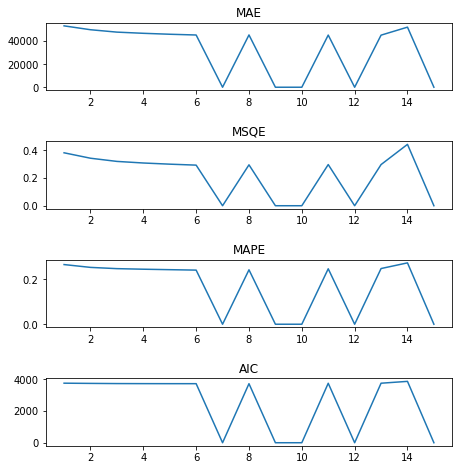

In [82]:
Average_MAPE = []
CrossVal_MAPE = []
Average_MAE = []
CrossVal_MAE = []
Average_MSQE = []
CrossVal_MSQE = []
Average_AIC = []
CrossVal_AIC = []
for j in range(15):
    try:
        for i in range(20):
            CrossVal_MAPE.append(list(list(lista[i].values())[0][j].values())[0][0])
            CrossVal_MAE.append(list(list(lista[i].values())[0][j].values())[0][1])
            CrossVal_MSQE.append(list(list(lista[i].values())[0][j].values())[0][2])
            CrossVal_AIC.append(list(list(lista[i].values())[0][j].values())[0][3])
        Average_MAPE.append(np.mean(CrossVal_MAPE))
        Average_MAE.append(np.mean(CrossVal_MAE))
        Average_MSQE.append(np.mean(CrossVal_MSQE))
        Average_AIC.append(np.mean(CrossVal_AIC))
    except:
        Average_MAPE.append(0)
        Average_MAE.append(0)
        Average_MSQE.append(0)
        Average_AIC.append(0)
Verdadeiros_Erros = pd.DataFrame([Average_MAPE,Average_MAE,Average_MSQE,Average_AIC],index=['MAE','MSQE','MAPE','AIC']) 
Verdadeiros_Erros.columns = Verdadeiros_Erros.columns+1
fig, axs = plt.subplots(4,figsize = (7,7))
fig.tight_layout(pad=3.0)
axs[0].title.set_text("MAE")
axs[1].title.set_text("MSQE")
axs[2].title.set_text("MAPE")
axs[3].title.set_text("AIC")
axs[0].plot(Verdadeiros_Erros.transpose()['MAE'])
axs[1].plot(Verdadeiros_Erros.transpose()['MSQE'])
axs[2].plot(Verdadeiros_Erros.transpose()['MAPE'])
axs[3].plot(Verdadeiros_Erros.transpose()['AIC'])
Verdadeiros_Erros.transpose().sort_values(by =['MAPE','AIC','MSQE'])[Verdadeiros_Erros.transpose()['MAE'] != 0]

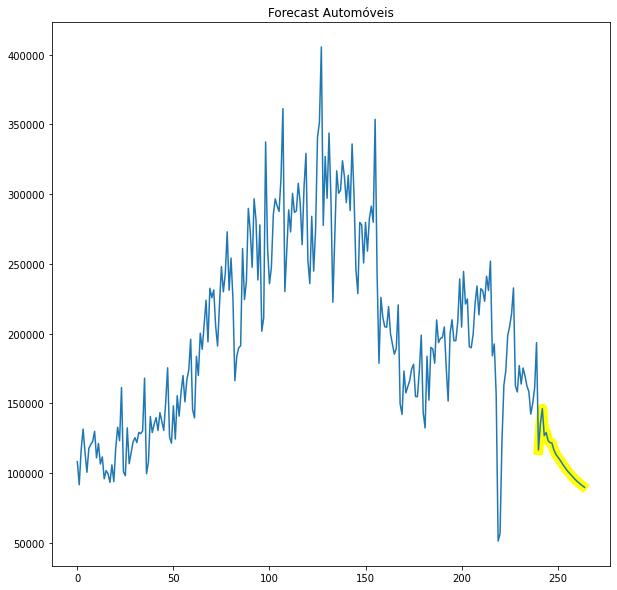

In [85]:
var_model = VARMAX(df_caminhoes[['Câmbio','Automóveis_Com_Emplac']],order =(6,0), enforce_stationarity=True)
fitted_model = var_model.fit(disp=False)
predict = fitted_model.get_prediction(start=len(df_caminhoes),end=len(df_caminhoes) + 24 -1)
predictions = predict.predicted_mean
predictions.rename(columns = {'Câmbio':'Câmbio_Forecast','Automóveis_Com_Emplac':'Automóveis_Com_Emplac_Forecast'},inplace=True)
Forecast = pd.concat([df_caminhoes['Automóveis_Com_Emplac'],predictions['Automóveis_Com_Emplac_Forecast']])
fig, axs = plt.subplots(1,figsize=(10,10))

axs.plot(Forecast[240:264], lw=10, c='yellow', zorder=-1)
axs.plot(Forecast)
axs.title.set_text(f'Forecast Automóveis')

In [87]:
from pmdarima import auto_arima

df_caminhoes.set_index('Data')
stepwise_fit = auto_arima(df_caminhoes['Caminhões_Emplac'],
                          trace = True, suppress_warnings=True)

stepwise_fit.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4109.219, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4147.592, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4133.728, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4123.300, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4145.617, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4107.532, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4120.763, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4122.517, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4109.363, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4117.645, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4121.395, Time=0.05 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4105.809, Time=0.22 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4106.448, Time=0.27 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=4104.970, Time=0.37 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  241
Model:               SARIMAX(5, 1, 4)   Log Likelihood               -2032.858
Date:                Tue, 08 Mar 2022   AIC                           4087.715
Time:                        02:05:03   BIC                           4126.002
Sample:                             0   HQIC                          4103.142
                                - 241                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     41.1108     94.544      0.435      0.664    -144.192     226.413
ar.L1         -0.3682      0.444     -0.829      0.407      -1.238       0.502
ar.L2         -0.5208      0.490     -1.063      0.288      -1.481       0.440
ar.L3          0.0074      0.656      0.011      0.991      -1.278       1.293
ar.L4          0.4546      0.477      0.953      0.340      -0.480       1.389
ar.L5          0.3433      0.229      1.500      0.134      -0.105       0.792
ma.L1          0.1156      0.427      0.271      0.786      -0.720       0.952
ma.L2          0.2635      0.365      0.722      0.470      -0.452       0.979
ma.L3         -0.0496      0.439     -0.113      0.910      -0.909       0.810
ma.L4         -0.6947      0.318     -2.183      0.029      -1.318      -0.071
sigma2       1.46e+06   1.22e+05     11.957      0.000    1.22e+06     1.7e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                57.59
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.68   Skew:                            -0.43
Prob(H) (two-sided):                  0.02   Kurtosis:                         5.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [98]:
from statsmodels.tsa.arima.model import ARIMA
Train_Cam = df_caminhoes['Caminhões_Emplac'].iloc[:-24]
Test_Cam = df_caminhoes['Caminhões_Emplac'].iloc[-24:]
arima1 = ARIMA(Train_Cam, order=(5,1,4))
arima1 = arima1.fit()
Prediction = arima1.predict(start = len(Train_Cam), end = len(Train_Cam) + len(Test_Cam) +1, typ = 'levels')
Prediction.index = df_caminhoes['Data'][-26:]


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


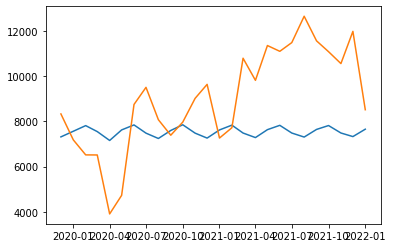

In [107]:
Prediction1 =pd.DataFrame(Prediction)
plt.plot(Prediction1)
plt.plot(df_caminhoes.set_index('Data')['Caminhões_Emplac'].iloc[-26:])

In [109]:
Previsão_Final = df_caminhoes['Caminhões_Emplac']
arima1 = ARIMA(Previsão_Final, order=(5,1,4))
arima1 = arima1.fit()
Prediction = arima1.predict(start = len(Previsão_Final), end = len(Previsão_Final) +25, typ = 'levels')

d:\python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [118]:
Prediction

241     8863.486052
242    10295.295492
243     9313.046465
244     9457.311400
245     8803.038346
246     9732.351239
247     9766.076639
248     8952.520361
249     9000.059226
250     9573.363212
251     9653.070385
252     8950.184885
253     8900.008355
254     9549.891875
255     9545.178364
256     8903.575635
257     8871.932988
258     9482.996229
259     9475.733773
260     8854.483606
261     8848.251820
262     9429.486725
263     9407.192259
264     8817.495723
265     8826.901231
266     9382.549904
Name: predicted_mean, dtype: float64

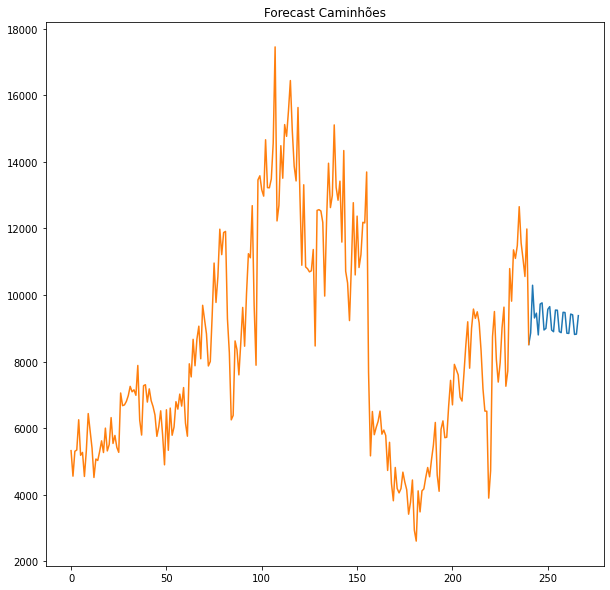

In [124]:
Forecast_Caminhões = pd.concat([df_caminhoes['Caminhões_Emplac'],Prediction])
fig, axs = plt.subplots(1,figsize=(10,10))

axs.title.set_text(f'Forecast Caminhões')
axs.plot(Forecast_Caminhões[240:])
axs.plot(Forecast_Caminhões[:241])